In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras.models import Model
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import SpeechGenerator
import librosa
#from keras import losses

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


In [2]:
# Root folder of the dataset
dataset_dir = "Dataset/"

In [3]:
# File containing the path that identify the test and validation set
testWAVs = pd.read_csv(dataset_dir + 'testing_list.txt', sep=" ", header = None)[0].tolist()
valWAVs  = pd.read_csv(dataset_dir + 'validation_list.txt', sep=" ", header = None)[0].tolist()

In [4]:
# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0, 'follow':0, 
              'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0, 'visual':0, 'wow':0 }
nCategs = 21

In [5]:
# Load all the file in dataset
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    for f in files:
        if (root != dataset_dir + "_background_noise_") and (f.endswith('.wav')):
            path = root + "/" + f
            #print(path)
            path = path[len(dataset_dir):]
            #print(path)
            allWAVs.append(path)

# Remove from the training set the elements present in test and validation
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

In [6]:
# Size of sets
print("Train set length: " + str(len(trainWAVs)))
print("Validation set length: " + str(len(valWAVs)))
print("Test set length: " + str(len(testWAVs)))

Train set length: 84843
Validation set length: 9981
Test set length: 11005


In [7]:
# Function to extract the category from the path to the file
def _getFileCategory(file, catDict):
    # Receives a file with name <cat>/<filename> and returns an integer that is catDict[cat]
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [8]:
# Get categories of each set
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

# And test the size of the labels set
print("Train-Labels set length: " + str(len(trainWAVlabels)))
print("Validation-Labels set length: " + str(len(valWAVlabels)))
print("Test-Labels set length: " + str(len(testWAVlabels)))

Train-Labels set length: 84843
Validation-Labels set length: 9981
Test-Labels set length: 11005


In [9]:
# Transoform the train dataset in numpy array and load them 
train = np.array(trainWAVs, dtype = object)
trainLabels = np.array(trainWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the train set:")
for i in range(len(trainWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(trainWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + trainWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + trainWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + trainWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    train[i] = trainWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(trainWAVs)))

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843


In [10]:
# Do the same thing for the validation and the test set
val = np.array(valWAVs, dtype = object)
valLabels = np.array(valWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the validation set:")
for i in range(len(valWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(valWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + valWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + valWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + valWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    val[i] = valWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(valWAVs)))

test = np.array(testWAVs, dtype = object)

print("Loading of the test set:")
for i in range(len(testWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(testWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + testWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + testWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + testWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    test[i] = testWAVs[i] + '.npy' 
    
print(str(i+1) + '/' + str(len(testWAVs)))

Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


In [11]:
#test on the length
print(str(len(trainWAVs)) + " = " + str(len(train)))
print(str(len(valWAVs)) + " = " + str(len(val)))
print(str(len(testWAVs)) + " = " + str(len(test)))

#test on labels 
for i in range(0, 1):
    print("file: " + train[i] + " - label: " + str(trainLabels[i]))
    print("file: " + trainWAVs[i] + " - label: " + str(trainLabels[i]))

84843 = 84843
9981 = 9981
11005 = 11005
file: off/a8cb6dda_nohash_0.wav.npy - label: 9
file: off/a8cb6dda_nohash_0.wav - label: 9


Text(0.5, 1.0, 'WAV signal')

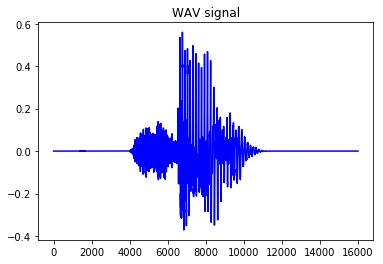

In [12]:
# Function to load numpy array
def load_data(file_name, data_dir):
    # Load the wav signal from the .npy file
    data = np.load(data_dir + file_name)
    return data

# Plot a wav
file_name = train[25]
data = load_data(file_name, dataset_dir)
plt.figure()
plt.plot(data, color='b')
plt.title('WAV signal')

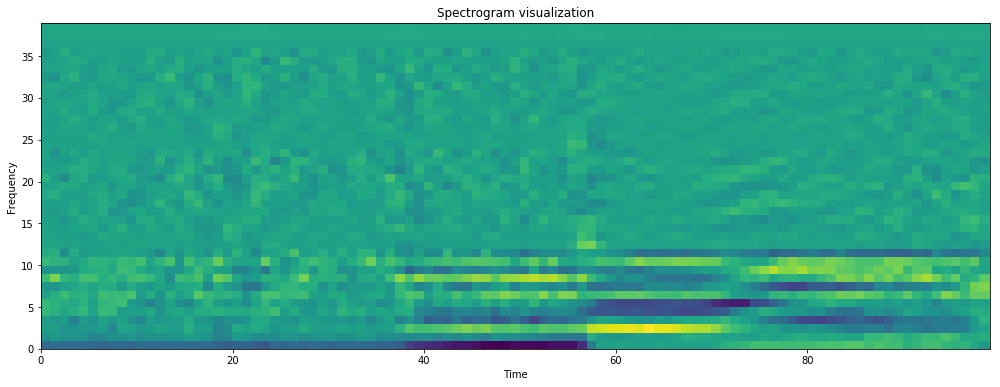

File: sheila/329eab8a_nohash_2.wav.npy - Label: 0


In [13]:
# Function to preprocess the data 
def load_and_preprocess_data(file_name, data_dir):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
        data_dir = data_dir.decode()

    # Load data
    data = load_data(file_name, data_dir)
    feats = computeFeatures1(data, 16000)
    # Normalize
    #feats -= (np.mean(feats, axis=0) + 1e-8)
    #mean = np.mean(feats, axis = 0)
    #stv = np.std(feats, axis = 0)
    #diff = np.subtract(feats, mean)
    #feats = np.divide(diff, stv)

    return feats.astype(np.float32)

# example:
index = 26257
feats = load_and_preprocess_data(train[index], dataset_dir)
feats = np.transpose(feats)
#plt.plot(feats, color='b')
plt.figure(figsize=(17,6))
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))
#print(np.max(feats))

In [14]:
def create_dataset(data_dir, file_names, labels, batch_size = 32, shuffle = True, cache_file = None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.numpy_function (load_and_preprocess_data, [file_name, data_dir], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls = os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely (capire bene anche questo repeat come funziona)
    dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))
    
    # Batch
    dataset = dataset.batch(batch_size = batch_size)
    
    # Prefetch (1 means that prefetch a batch at time)
    dataset = dataset.prefetch(buffer_size = 1)
    
    return dataset


In [15]:
batch_size = 32

train_dataset = create_dataset(dataset_dir, train, trainLabels, batch_size = batch_size, shuffle = True, cache_file = 'train_cache')

val_dataset = create_dataset(dataset_dir, val, valLabels, batch_size = batch_size, shuffle = False, cache_file = 'val_cache')

test_dataset = create_dataset(dataset_dir, test, testWAVlabels, batch_size = 1, shuffle = False, cache_file = 'test_cache')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))

print("steps per completare un epoca di train: " + str(train_steps))
print("steps per completare un epoca di validation: " + str(val_steps))

steps per completare un epoca di train: 2652
steps per completare un epoca di validation: 312


In [16]:
model = Model.AttentionModel(nCategs, 99, 39, use_GRU = True, dropout = 0.1, activation = 'relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 39, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 39, 10)   60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 39, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 39, 1)    31          batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
# questa funzione sembra essere difficile da applicare ad un fit normale, si può provare ma intanto ho provato ad usare 
# l'exp_decay che si da in ingresso all'optimizer
import math
def step_decay(lr):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_crossentropy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('Model/my_model_loss_dropout-0_05-yes_reg-0.h5', 
                               monitor='val_sparse_categorical_crossentropy', 
                               verbose=1, save_best_only = True, save_weights_only = True)

""" Stavo provando a vedere questa cosa che ho trovato in giro ma da lo stesso errore quindi nada
class LearningRateScheduler(tf.keras.callbacks.Callback):
    Learning rate scheduler which sets the learning rate according to schedule.

    Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
    

    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, '_lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print('\nEpoch %05d: Learning rate is %6.4f.' % (epoch, scheduled_lr))
    
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.05), (6, 0.01), (9, 0.005), (12, 0.001)
]

def lr_schedule(epoch, lr):
    Helper function to retrieve the scheduled learning rate based on epoch.
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr
"""

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

#    def on_train_batch_end(self, batch, logs=None):
#        print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

#    def on_test_batch_end(self, batch, logs=None):
#        print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

    def on_epoch_end(self, epoch, logs=None):
        print('The average loss for epoch {} is {:7.2f} and mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['sparse_categorical_accuracy']))


In [ ]:
# -Con decayed_lr funziona l'adaptive learning rate, cioè si può impostare un learning rate così(non per forza exp,
#  ce ne sono anche altri)

learning_rate = 0.001
global_step = tf.Variable(0, trainable = False)

decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, 10000,
                                        0.95, staircase = True)

adam = tf.train.AdamOptimizer(decayed_lr, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

#print(float(tf.keras.backend.get_value(model.optimizer._learning_rate)))

num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [LossAndErrorPrintingCallback(), checkpointer, earlystopper])

#print(history.history.keys())

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Train acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Val acc')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Epoch 1/10
  17/2652 [..............................] - ETA: 1:48:15 - loss: 0.8066 - sparse_categorical_accuracy: 0.7371

In [ ]:
# Save the model
model.save('Model/AttentionModel-1_00-0107-11.h5')

testEval = model.evaluate(test_dataset, verbose = 1)

In [ ]:
x = "tree/022cd682_nohash_1.wav.npy"
x = load_and_preprocess_data(x, dataset_dir).reshape((1, 99, 39, 1))
print(x.shape)
res = model.predict(x) 
print(res.argmax())